In [1]:
import pandas as pd
import datetime as dt

In [44]:
df=pd.read_csv("cleaneddata.csv")

Check missing values

In [45]:
df.isnull().sum()

Unnamed: 0     0
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [4]:
df.shape

(397924, 9)

Get total price

In [46]:
df["TotalPrice"]=df["Quantity"]*df['UnitPrice']

Get the rfmTable

In [6]:
df['InvoiceDate'].min()

'2010-12-01 08:26:00'

In [7]:
df['InvoiceDate'].max()

'2011-12-09 12:50:00'

In [47]:
# the last day is 2011-12-09, so we will use 2011-12-10 to calculate recency

NOW = dt.datetime(2011,12,10)
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

In [48]:
rfmTable = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalPrice': lambda x: x.sum()})

In [49]:
rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'TotalPrice': 'monetary_value'}, inplace=True)

In [50]:
rfmTable.head()

,recency,frequency,monetary_value
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40


Split the metrics

In [51]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
segmented_rfm = rfmTable

In [52]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [53]:
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12347.0,2,182,4310.00,1,1,1
12348.0,75,31,1797.24,3,3,1
12349.0,18,73,1757.55,2,2,1
12350.0,310,17,334.40,4,4,3


Get the RFMScore

In [54]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str)  + segmented_rfm.f_quartile.map(str)  + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
12346.0,325,1,77183.60,4,4,1,441
12347.0,2,182,4310.00,1,1,1,111
12348.0,75,31,1797.24,3,3,1,331
12349.0,18,73,1757.55,2,2,1,221
12350.0,310,17,334.40,4,4,3,443


Get the best customers

In [55]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False)

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
14646.0,1,2080,280206.02,1,1,1,111
18102.0,0,431,259657.30,1,1,1,111
17450.0,8,337,194550.79,1,1,1,111
14911.0,1,5677,143825.06,1,1,1,111
14156.0,9,1400,117379.63,1,1,1,111
17511.0,2,963,91062.38,1,1,1,111
16684.0,4,277,66653.56,1,1,1,111
14096.0,4,5111,65164.79,1,1,1,111
13694.0,3,568,65039.62,1,1,1,111


In [56]:
from sklearn import preprocessing
import numpy as np
from scipy.stats import zscore
from scipy import stats

In [57]:
segmented_rfm['logrecency']=stats.zscore(np.log(segmented_rfm['recency']+0.1))

In [60]:
segmented_rfm['logfrequency']=stats.zscore(np.log(segmented_rfm['frequency']+0.1))
segmented_rfm['logmv']=stats.zscore(np.log(segmented_rfm['monetary_value']+0.1))

In [64]:
X=segmented_rfm[['logrecency','logfrequency','logmv']]

In [86]:
from sklearn.cluster import KMeans

# Number of clusters
kmeans = KMeans(n_clusters=5)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_

In [83]:
centroids

array([[ 0.02937221,  0.26189263,  0.18217006],
       [ 0.67547971, -0.96281691, -0.90710058],
       [-1.26740202,  1.16472973,  1.23375131]])

In [74]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

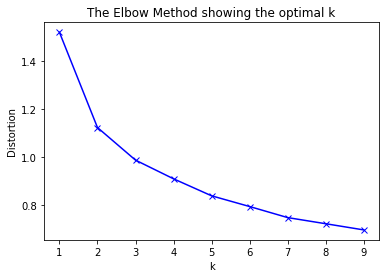

In [93]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()
##When K increases, the centroids are closer to the clusters centroids.

##The improvements will decline, at some point rapidly, creating the elbow shape.

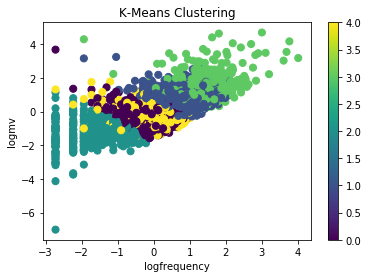

In [92]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(segmented_rfm['logfrequency'],segmented_rfm['logmv'],
                     c=labels,s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('logfrequency')
ax.set_ylabel('logmv')
plt.colorbar(scatter)

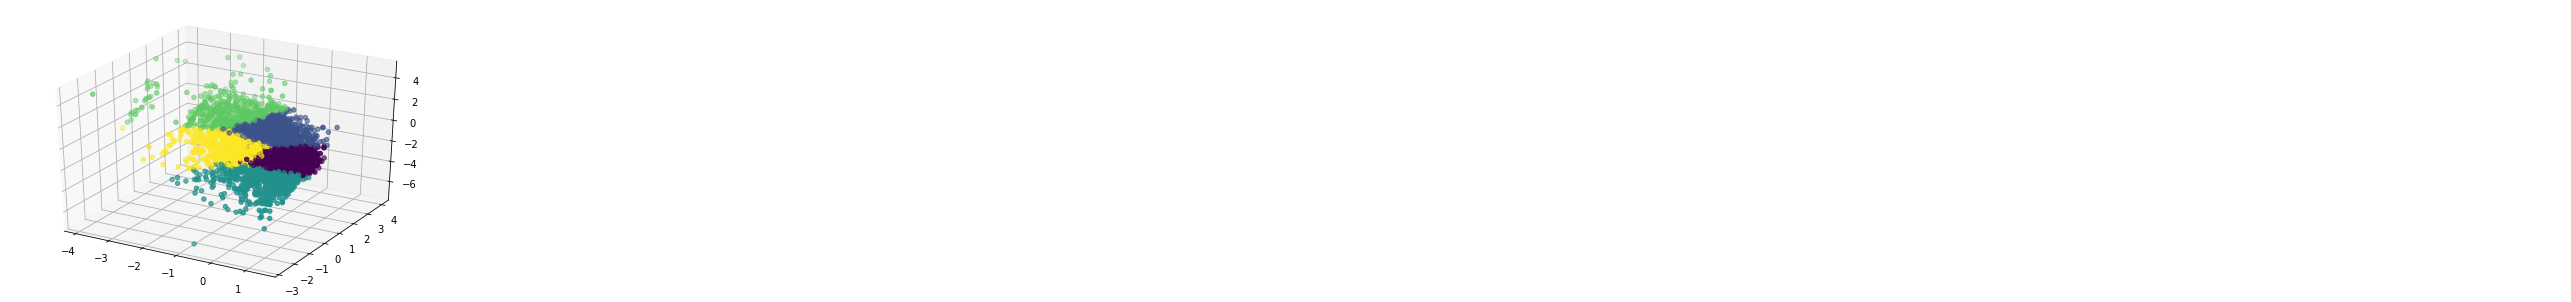

In [89]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(segmented_rfm['logrecency'], segmented_rfm['logfrequency'], segmented_rfm['logmv'], c=labels)

